## 0. Goal
Apply the trained VAE model to all sorted audio data to obtain latent features. 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle, gc, shutil
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter, OrderedDict
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage import transform
import gc

plt.rcParams['pdf.fonttype'] = 42 

In [3]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [4]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [5]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdID = 'pair5RigCCU29'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clim = [1.5,7]
# where are wav files and segmentation located
fd_save_base = os.path.join(fd_data, birdID, 'Traj', 'applySylAll')
fd_wav = os.path.join(fd_save_base, 'AudioAll1')
# how large is sliding window
win_frame = 32
# what VAE model to use
vae_run = 'traj_chop_32_1_32'
fd_vae = '/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/VAE5/traj_chop_32_1_32/'
fn_vae = os.path.join(fd_vae, f'{birdID}_checkpoint_final.tar')

In [6]:
# define parameters for spectrograms
X_SHAPE = [128, 128]
p = {
    'get_spec': vae_goffinet.get_specZZ, # spectrogram maker
    'max_dur': 1e9, # maximum syllable duration
    'min_freq': 250, # minimum frequency
    'max_freq': 7500, # maximum frequency, default 7500
    'num_freq_bins': X_SHAPE[0], # hard-coded
    'num_time_bins': X_SHAPE[1], # hard-coded
    'nperseg': 256, # FFT
    'noverlap': 236, # FFT, determines window overlap when calculating spectrograms
    'spec_min_val': clim[0], # minimum log-spectrogram value
    'spec_max_val': clim[1], # maximum log-spectrogram value
    'fs': 20000, # audio samplerate
    'mel': False, # frequency spacing, mel or linear
    'time_stretch': False, # stretch short syllables?
    'within_syll_normalize': False, # normalize spectrogram values on a # spectrogram-by-spectrogram basis
    'pad': 0.08,  # when extracting syllables for calculating spectrograms, pad before syllable onset and after syllable onset, unit is sec
    'win_frame': win_frame,  # duration of the sliding window, unit is spectrogram column
    'hop_frame': 1, # how much to slide for consecutive window, unit is spectrogram column
    'win_pad': win_frame, # how much to include before syllable onset, unit is spectrogram column, default to one sliding window
}

## 2. Make spectrograms for all sorted audio

In [7]:
# where to save syllable spectrogram results
spec_suffix = 'SpectrogramAll1'

In [8]:
bd = birdID
print(f'Processing for {bd}...')
win_ms = p['nperseg']/p['fs']*1000
hop_ms = (p['nperseg']-p['noverlap'])/p['fs']*1000
print(f'Spectrograming window size (ms): {win_ms:.3f}')
print(f'Spectrograming window hop (ms): {hop_ms:.3f}')
## given the current run a name
run_name = f'spec_goffinet_traj_{p["nperseg"]}_{p["noverlap"]}'
print(run_name)

# save to specific folder
fd_save = os.path.join(fd_save_base, spec_suffix)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
fn_h5 = os.path.join(fd_save, f'{bd}.{run_name}.h5')
fn_info = os.path.join(fd_save, f'{bd}.{run_name}.info.csv')
print('Save syllable spectrogram as: ', fn_h5)
print(fn_info)

Processing for pair5RigCCU29...
Spectrograming window size (ms): 12.800
Spectrograming window hop (ms): 1.000
spec_goffinet_traj_256_236
Save syllable spectrogram as:  /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySylAll/SpectrogramAll1/pair5RigCCU29.spec_goffinet_traj_256_236.h5
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySylAll/SpectrogramAll1/pair5RigCCU29.spec_goffinet_traj_256_236.info.csv


In [9]:
## grab all wav files
fns_wav = sorted(glob.glob(os.path.join(fd_wav, '*', '*', '*.wav')))
fns_label = sorted(glob.glob(os.path.join(fd_wav, '*', '*', '*.label.txt')))
print(len(fns_wav))

2226


In [10]:
## calculate spectrogram for all syllables
syl = []
print('Calculating spectrograms...')
with Parallel(n_jobs=48, verbose=5) as parallel:
    res = parallel(delayed(vae_goffinet.ZZ_specFromWavTraj_v1)(fn, p, syl) for fn in fns_wav)

# flatten the result
temp = [aa[0] for aa in res]
specs = [arr for sublist in temp if sublist for arr in sublist]
df_list = [aa[1] for aa in res]
info = pd.concat([df for df in df_list if not df.empty], ignore_index=True)
print(len(specs), info.shape)

Calculating spectrograms...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:   11.2s
[Parallel(n_jobs=48)]: Done 192 tasks      | elapsed:   14.2s
[Parallel(n_jobs=48)]: Done 354 tasks      | elapsed:   18.2s
[Parallel(n_jobs=48)]: Done 552 tasks      | elapsed:   23.3s
[Parallel(n_jobs=48)]: Done 786 tasks      | elapsed:   29.2s
[Parallel(n_jobs=48)]: Done 1056 tasks      | elapsed:   34.7s
[Parallel(n_jobs=48)]: Done 1362 tasks      | elapsed:   42.1s
[Parallel(n_jobs=48)]: Done 1704 tasks      | elapsed:   49.9s
[Parallel(n_jobs=48)]: Done 2082 tasks      | elapsed:   57.4s


95064 (95064, 12)


[Parallel(n_jobs=48)]: Done 2226 out of 2226 | elapsed:  1.0min finished


In [11]:
## save results
# save padded spectrograms as h5 file 
with h5py.File(fn_h5, "w") as f:
    for i, spec in enumerate(specs):
        f.create_dataset(f"spec_{i}", data=spec, compression="gzip")

# save meta info as well
print(info.shape)
info.to_csv(fn_info)

(95064, 12)


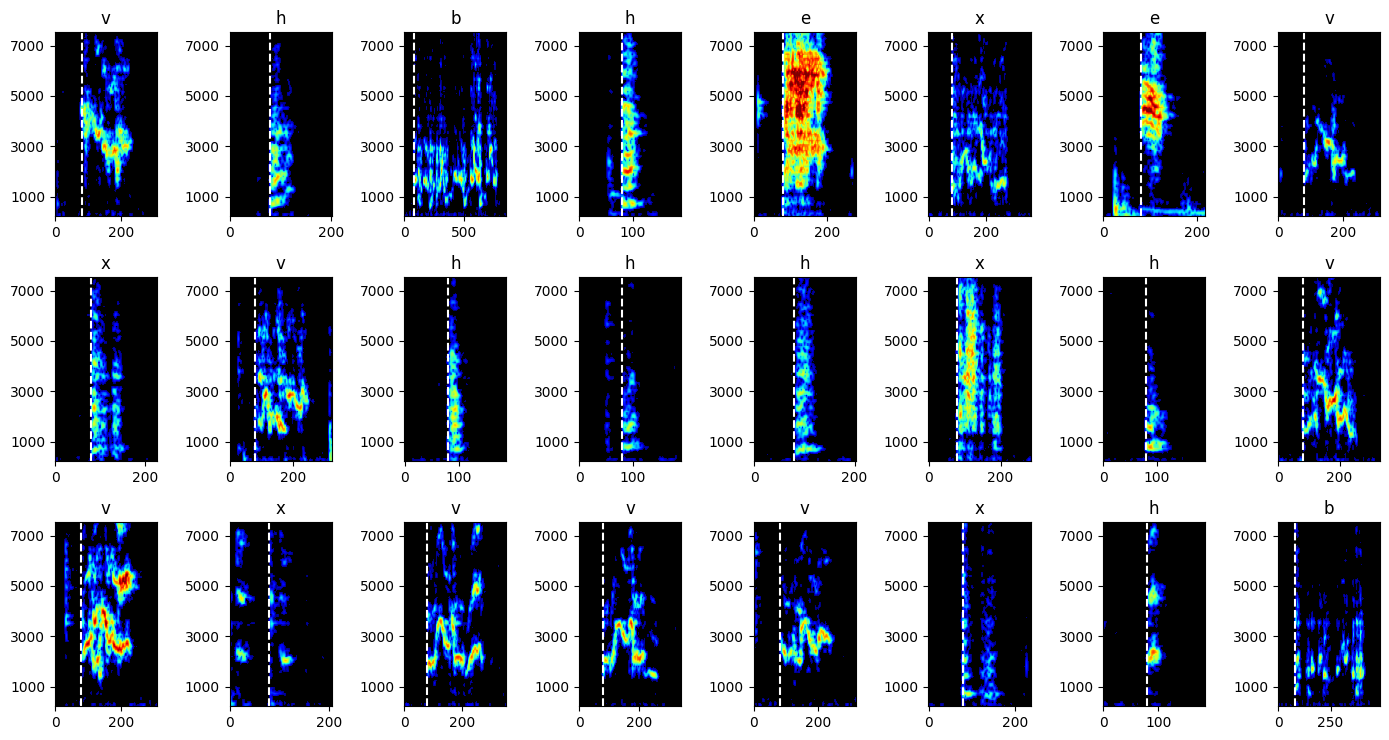

In [12]:
# plot some example spectrograms
nrow = 3
ncol = 8
random.seed(1118)
idx_rd = random.sample(range(len(specs)), nrow*ncol)
fig, axes = plt.subplots(nrow, ncol, figsize=(14, nrow*2.5))
xmax = max([specs[ii].shape[1] for ii in idx_rd])
for ii in range(len(idx_rd)):
    plot_i = ii//ncol
    plot_j = ii%ncol
    ax = axes[plot_i][plot_j]
    ax.imshow(specs[idx_rd[ii]], aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')
    ax.set_title(info.loc[idx_rd[ii], 'label'])
    # set y tick labels
    query_freqs = [1000, 3000, 5000, 7000]
    target_freqs = info.loc[idx_rd[ii], 'spec_f']
    indices = np.arange(len(target_freqs))
    # Interpolate: given a value, find where it lies in the index space
    interp_indices = np.interp(query_freqs, target_freqs, indices)
    ax.set_yticks(interp_indices)
    ax.set_yticklabels(query_freqs)
    # ax.set_xlim(0, xmax)
    ax.axvline(x=p['pad']*1000/hop_ms, color='white', linestyle='--')
plt.tight_layout()
plt.show()
# save figure
fn_fig = os.path.join(fd_save, f'{bd}.{run_name}.pdf')
fig.savefig(fn_fig)


In [18]:
info.head()

,fn_wav,s_idx,istart,iend,label,spec_f,spec_t,i_start,i_end,zero_start,zero_end,rel_ori
0,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,0,660,3400,x,"[250.0, 307.0866141732283, 364.1732283464567, ...","[0.0, 0.001, 0.001999999999999999, 0.003, 0.00...",0,5000,940,0,1600
1,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,1,5740,12940,b,"[250.0, 307.0866141732283, 364.1732283464567, ...","[0.0, 0.001, 0.001999999999999999, 0.003, 0.00...",4140,14540,0,0,1600
2,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,2,18800,20000,x,"[250.0, 307.0866141732283, 364.1732283464567, ...","[0.0, 0.001, 0.001999999999999999, 0.003, 0.00...",17200,20860,0,740,1600
3,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,3,20860,24800,v,"[250.0, 307.0866141732283, 364.1732283464567, ...","[0.0, 0.001, 0.001999999999999999, 0.003, 0.00...",20000,26400,740,0,1600
4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,4,28880,38480,b,"[250.0, 307.0866141732283, 364.1732283464567, ...","[0.0, 0.001, 0.001999999999999999, 0.003, 0.00...",27280,40080,0,0,1600


In [23]:
# release RAM
del specs, spec
del info
gc.collect()

1693

## 3. Slide all syllables into spectrogram windows, obtain VAE latent

In [9]:
# where to save results
fd_save_latent = os.path.join(fd_save_base, f'latents.{vae_run}')
if os.path.exists(fd_save_latent):
    shutil.rmtree(fd_save_latent)
os.makedirs(fd_save_latent)
print('Save latents to: ', fd_save_latent)

Save latents to:  /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySylAll/latents.traj_chop_32_1_32


In [10]:
# load the VAE model
model = vae_goffinet.VAE(save_dir=fd_vae)
model.load_state(fn_vae)

In [11]:
# loop through all syllables
bd = birdID
fn_spec = os.path.join(fd_save, f'{bd}.{run_name}.h5')
fn_info = os.path.join(fd_save, f'{bd}.{run_name}.info.csv')
info_syl = pd.read_csv(fn_info, index_col=0)
info_syl.shape

(95064, 12)

In [12]:
# analyze in batches
idx_v = info_syl.index

b_size = 240
b_starts = list(range(0, len(idx_v), b_size))
if b_starts[-1]!=len(idx_v):
    b_starts.append(len(idx_v))
# loop through batches
print('Total number of batches: ',len(b_starts)-1)
for b_i in range(len(b_starts)-1):
# for b_i in range(3):
    bs = b_starts[b_i]
    be = b_starts[b_i+1]
    # chop 
    with Parallel(n_jobs=48, verbose=0) as parallel:
        res = parallel(delayed(vae_goffinet.ZZ_slideSylWin_v1)(fn_spec, ri, p, resize=True) for ri in idx_v[bs:be])  

    # flatten the result
    temp = [aa[0] for aa in res]
    specs = [arr for sublist in temp if sublist for arr in sublist]
    spec_win_all = np.stack(specs, axis=0)
    df_list = [aa[1] for aa in res]
    info = pd.concat([df for df in df_list if not df.empty], ignore_index=True)
    print(spec_win_all.shape, info.shape)

    # convert to datasets
    X_tensor = torch.from_numpy(spec_win_all).float()
    dataset = TensorDataset(X_tensor)
    # Create DataLoader
    train_dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)  

    # loop through dataloader, obtain model latent space
    latent_m = np.zeros((info.shape[0], 32))
    latent_d = np.zeros((info.shape[0], 32))
    # recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
    model.eval()
    count = 0
    for i, data in tqdm.tqdm(enumerate(train_dataloader)):
        data = data[0].to('cuda:0')
        with torch.no_grad():
            _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
            a = mu.shape[0]
            latent_m[count:(count+a),:] = mu
            latent_d[count:(count+a),:] = d
            # recon[count:(count+a),:,:] = rec
            count += a

    # save the latent representations
    fn_latentM = os.path.join(fd_save_latent, f'latentM.{b_i:06d}.csv')
    np.savetxt(fn_latentM, latent_m, delimiter=',')
    fn_latentD = os.path.join(fd_save_latent, f'latentD.{b_i:06d}.csv')
    np.savetxt(fn_latentD, latent_d, delimiter=',')
    fn_info = os.path.join(fd_save_latent, f'info.{b_i:06d}.csv')
    info.to_csv(fn_info)
    print(latent_m.shape)

Total number of batches:  397
(39938, 128, 128) (39938, 4)


0it [00:00, ?it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
625it [00:04, 130.29it/s]


(39938, 32)
(40161, 128, 128) (40161, 4)


615it [00:04, 152.20it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
628it [00:04, 136.14it/s]


(40161, 32)
(42023, 128, 128) (42023, 4)


651it [00:04, 157.21it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
657it [00:04, 137.69it/s]


(42023, 32)
(43729, 128, 128) (43729, 4)


683it [00:04, 152.54it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
684it [00:04, 137.17it/s]


(43729, 32)
(40112, 128, 128) (40112, 4)


619it [00:04, 154.92it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
627it [00:04, 135.94it/s]


(40112, 32)
(44205, 128, 128) (44205, 4)


683it [00:04, 152.72it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
691it [00:05, 137.20it/s]


(44205, 32)
(36877, 128, 128) (36877, 4)


570it [00:03, 152.15it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
577it [00:04, 134.67it/s]


(36877, 32)
(43303, 128, 128) (43303, 4)


677it [00:04, 137.80it/s]


(43303, 32)
(46375, 128, 128) (46375, 4)


725it [00:05, 137.42it/s]


(46375, 32)
(42973, 128, 128) (42973, 4)


667it [00:04, 157.70it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
672it [00:04, 136.90it/s]


(42973, 32)
(44808, 128, 128) (44808, 4)


696it [00:04, 154.37it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
701it [00:05, 136.19it/s]


(44808, 32)
(46397, 128, 128) (46397, 4)


713it [00:04, 152.91it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
725it [00:05, 137.36it/s]


(46397, 32)
(44367, 128, 128) (44367, 4)


685it [00:04, 156.01it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
694it [00:05, 137.04it/s]


(44367, 32)
(41654, 128, 128) (41654, 4)


648it [00:04, 154.53it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
651it [00:04, 136.33it/s]


(41654, 32)
(41934, 128, 128) (41934, 4)


651it [00:04, 154.91it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
656it [00:04, 136.93it/s]


(41934, 32)
(39400, 128, 128) (39400, 4)


603it [00:03, 151.96it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
616it [00:04, 134.74it/s]


(39400, 32)
(47361, 128, 128) (47361, 4)


730it [00:04, 156.22it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
741it [00:05, 136.90it/s]


(47361, 32)
(44053, 128, 128) (44053, 4)


683it [00:04, 153.31it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
689it [00:05, 135.47it/s]


(44053, 32)
(38985, 128, 128) (38985, 4)


604it [00:03, 157.33it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
610it [00:04, 136.72it/s]


(38985, 32)
(49916, 128, 128) (49916, 4)


779it [00:05, 154.36it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
780it [00:05, 139.67it/s]


(49916, 32)
(47376, 128, 128) (47376, 4)


733it [00:04, 153.03it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
741it [00:05, 137.19it/s]


(47376, 32)
(28884, 128, 128) (28884, 4)


440it [00:02, 150.67it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
452it [00:03, 128.36it/s]


(28884, 32)
(48331, 128, 128) (48331, 4)


749it [00:04, 152.29it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
756it [00:05, 138.38it/s]


(48331, 32)
(44723, 128, 128) (44723, 4)


697it [00:04, 151.98it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
699it [00:05, 135.13it/s]


(44723, 32)
(48781, 128, 128) (48781, 4)


763it [00:05, 138.40it/s]


(48781, 32)
(43849, 128, 128) (43849, 4)


686it [00:05, 134.88it/s]


(43849, 32)
(38909, 128, 128) (38909, 4)


608it [00:04, 134.58it/s]


(38909, 32)
(44807, 128, 128) (44807, 4)


699it [00:04, 153.13it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
701it [00:05, 135.53it/s]


(44807, 32)
(40419, 128, 128) (40419, 4)


618it [00:04, 155.64it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
632it [00:04, 135.19it/s]


(40419, 32)
(51199, 128, 128) (51199, 4)


789it [00:05, 155.64it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
800it [00:05, 136.60it/s]


(51199, 32)
(41040, 128, 128) (41040, 4)


642it [00:04, 133.54it/s]


(41040, 32)
(50809, 128, 128) (50809, 4)


779it [00:05, 155.39it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
794it [00:05, 138.70it/s]


(50809, 32)
(48620, 128, 128) (48620, 4)


745it [00:04, 152.56it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
760it [00:05, 135.86it/s]


(48620, 32)
(47841, 128, 128) (47841, 4)


748it [00:05, 137.62it/s]


(47841, 32)
(42717, 128, 128) (42717, 4)


668it [00:04, 134.80it/s]


(42717, 32)
(47948, 128, 128) (47948, 4)


743it [00:04, 156.07it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
750it [00:05, 135.50it/s]


(47948, 32)
(43761, 128, 128) (43761, 4)


675it [00:04, 155.97it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
684it [00:05, 133.71it/s]


(43761, 32)
(43333, 128, 128) (43333, 4)


664it [00:04, 155.24it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
678it [00:05, 134.46it/s]


(43333, 32)
(41944, 128, 128) (41944, 4)


645it [00:04, 152.45it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
656it [00:04, 133.80it/s]


(41944, 32)
(45990, 128, 128) (45990, 4)


713it [00:04, 152.46it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
719it [00:05, 133.93it/s]


(45990, 32)
(44571, 128, 128) (44571, 4)


681it [00:04, 151.21it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
697it [00:05, 136.25it/s]


(44571, 32)
(39586, 128, 128) (39586, 4)


605it [00:03, 156.47it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
619it [00:04, 134.33it/s]


(39586, 32)
(43749, 128, 128) (43749, 4)


669it [00:04, 156.00it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
684it [00:04, 137.60it/s]


(43749, 32)
(52755, 128, 128) (52755, 4)


819it [00:05, 152.71it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
825it [00:06, 135.87it/s]


(52755, 32)
(51281, 128, 128) (51281, 4)


802it [00:05, 137.76it/s]


(51281, 32)
(42946, 128, 128) (42946, 4)


672it [00:04, 136.23it/s]


(42946, 32)
(41125, 128, 128) (41125, 4)


643it [00:04, 134.99it/s]


(41125, 32)
(48964, 128, 128) (48964, 4)


763it [00:04, 155.74it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
766it [00:05, 136.46it/s]


(48964, 32)
(47381, 128, 128) (47381, 4)


741it [00:05, 135.87it/s]


(47381, 32)
(39927, 128, 128) (39927, 4)


617it [00:04, 152.91it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
624it [00:04, 132.61it/s]


(39927, 32)
(46050, 128, 128) (46050, 4)


720it [00:05, 135.66it/s]


(46050, 32)
(40328, 128, 128) (40328, 4)


631it [00:04, 132.26it/s]


(40328, 32)
(41331, 128, 128) (41331, 4)


646it [00:04, 133.37it/s]


(41331, 32)
(37471, 128, 128) (37471, 4)


585it [00:03, 152.27it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
586it [00:04, 130.89it/s]


(37471, 32)
(49700, 128, 128) (49700, 4)


775it [00:05, 154.81it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
777it [00:05, 136.46it/s]


(49700, 32)
(39479, 128, 128) (39479, 4)


617it [00:04, 134.36it/s]


(39479, 32)
(55260, 128, 128) (55260, 4)


863it [00:05, 153.42it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
864it [00:06, 136.06it/s]


(55260, 32)
(48609, 128, 128) (48609, 4)


760it [00:05, 135.89it/s]


(48609, 32)
(46637, 128, 128) (46637, 4)


729it [00:05, 135.72it/s]


(46637, 32)
(49081, 128, 128) (49081, 4)


767it [00:05, 135.87it/s]


(49081, 32)
(37854, 128, 128) (37854, 4)


583it [00:03, 155.30it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
592it [00:04, 131.96it/s]


(37854, 32)
(45088, 128, 128) (45088, 4)


699it [00:04, 156.22it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
705it [00:05, 135.06it/s]


(45088, 32)
(42193, 128, 128) (42193, 4)


660it [00:04, 133.44it/s]


(42193, 32)
(41312, 128, 128) (41312, 4)


646it [00:04, 134.56it/s]


(41312, 32)
(36076, 128, 128) (36076, 4)


564it [00:04, 132.44it/s]


(36076, 32)
(42212, 128, 128) (42212, 4)


660it [00:04, 134.81it/s]


(42212, 32)
(55583, 128, 128) (55583, 4)


869it [00:06, 137.71it/s]


(55583, 32)
(46387, 128, 128) (46387, 4)


725it [00:05, 135.66it/s]


(46387, 32)
(47406, 128, 128) (47406, 4)


727it [00:04, 153.58it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
741it [00:05, 134.17it/s]


(47406, 32)
(47753, 128, 128) (47753, 4)


747it [00:05, 137.58it/s]


(47753, 32)
(46006, 128, 128) (46006, 4)


719it [00:05, 134.37it/s]


(46006, 32)
(41172, 128, 128) (41172, 4)


644it [00:04, 133.52it/s]


(41172, 32)
(34966, 128, 128) (34966, 4)


539it [00:03, 153.02it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
547it [00:04, 130.88it/s]


(34966, 32)
(43891, 128, 128) (43891, 4)


686it [00:05, 134.80it/s]


(43891, 32)
(42595, 128, 128) (42595, 4)


666it [00:04, 133.59it/s]


(42595, 32)
(42757, 128, 128) (42757, 4)


669it [00:04, 136.68it/s]


(42757, 32)
(53038, 128, 128) (53038, 4)


829it [00:06, 136.27it/s]


(53038, 32)
(48914, 128, 128) (48914, 4)


761it [00:05, 154.50it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
765it [00:05, 134.42it/s]


(48914, 32)
(40184, 128, 128) (40184, 4)


617it [00:04, 152.39it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
628it [00:04, 133.50it/s]


(40184, 32)
(39920, 128, 128) (39920, 4)


624it [00:04, 133.31it/s]


(39920, 32)
(40091, 128, 128) (40091, 4)


627it [00:04, 133.49it/s]


(40091, 32)
(38642, 128, 128) (38642, 4)


601it [00:03, 153.86it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
604it [00:04, 132.20it/s]


(38642, 32)
(40255, 128, 128) (40255, 4)


629it [00:04, 134.04it/s]


(40255, 32)
(42957, 128, 128) (42957, 4)


672it [00:04, 134.53it/s]


(42957, 32)
(40888, 128, 128) (40888, 4)


639it [00:04, 133.81it/s]


(40888, 32)
(42286, 128, 128) (42286, 4)


661it [00:04, 136.17it/s]


(42286, 32)
(41048, 128, 128) (41048, 4)


642it [00:04, 135.14it/s]


(41048, 32)
(42005, 128, 128) (42005, 4)


657it [00:04, 135.62it/s]


(42005, 32)
(45562, 128, 128) (45562, 4)


697it [00:04, 153.57it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
712it [00:05, 135.77it/s]


(45562, 32)
(44713, 128, 128) (44713, 4)


695it [00:04, 154.17it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
699it [00:05, 133.91it/s]


(44713, 32)
(36108, 128, 128) (36108, 4)


565it [00:04, 130.28it/s]


(36108, 32)
(43474, 128, 128) (43474, 4)


680it [00:05, 135.15it/s]


(43474, 32)
(56227, 128, 128) (56227, 4)


879it [00:06, 137.33it/s]


(56227, 32)
(42974, 128, 128) (42974, 4)


672it [00:05, 133.14it/s]


(42974, 32)
(55937, 128, 128) (55937, 4)


875it [00:06, 136.50it/s]


(55937, 32)
(48919, 128, 128) (48919, 4)


757it [00:04, 155.85it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
765it [00:05, 136.21it/s]


(48919, 32)
(49672, 128, 128) (49672, 4)


777it [00:05, 138.71it/s]


(49672, 32)
(43850, 128, 128) (43850, 4)


681it [00:04, 153.86it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
686it [00:05, 134.72it/s]


(43850, 32)
(36258, 128, 128) (36258, 4)


567it [00:04, 131.49it/s]


(36258, 32)
(37133, 128, 128) (37133, 4)


581it [00:04, 134.03it/s]


(37133, 32)
(36398, 128, 128) (36398, 4)


569it [00:04, 131.65it/s]


(36398, 32)
(41469, 128, 128) (41469, 4)


648it [00:04, 132.72it/s]


(41469, 32)
(40623, 128, 128) (40623, 4)


633it [00:04, 150.84it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
635it [00:04, 131.54it/s]


(40623, 32)
(40219, 128, 128) (40219, 4)


629it [00:04, 132.49it/s]


(40219, 32)
(39044, 128, 128) (39044, 4)


611it [00:04, 133.03it/s]


(39044, 32)
(50812, 128, 128) (50812, 4)


794it [00:05, 137.38it/s]


(50812, 32)
(48896, 128, 128) (48896, 4)


764it [00:05, 137.73it/s]


(48896, 32)
(48788, 128, 128) (48788, 4)


763it [00:05, 135.50it/s]


(48788, 32)
(46357, 128, 128) (46357, 4)


725it [00:05, 134.41it/s]


(46357, 32)
(47070, 128, 128) (47070, 4)


736it [00:05, 134.37it/s]


(47070, 32)
(44493, 128, 128) (44493, 4)


696it [00:05, 134.55it/s]


(44493, 32)
(46052, 128, 128) (46052, 4)


720it [00:05, 136.44it/s]


(46052, 32)
(39823, 128, 128) (39823, 4)


623it [00:04, 131.76it/s]


(39823, 32)
(39450, 128, 128) (39450, 4)


602it [00:03, 153.78it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
617it [00:04, 133.30it/s]


(39450, 32)
(40769, 128, 128) (40769, 4)


638it [00:04, 132.46it/s]


(40769, 32)
(40293, 128, 128) (40293, 4)


630it [00:04, 132.28it/s]


(40293, 32)
(40622, 128, 128) (40622, 4)


635it [00:04, 132.97it/s]


(40622, 32)
(37166, 128, 128) (37166, 4)


581it [00:04, 131.45it/s]


(37166, 32)
(41411, 128, 128) (41411, 4)


635it [00:04, 154.26it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
648it [00:04, 133.85it/s]


(41411, 32)
(38785, 128, 128) (38785, 4)


607it [00:04, 131.43it/s]


(38785, 32)
(42107, 128, 128) (42107, 4)


650it [00:04, 153.08it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
658it [00:04, 133.98it/s]


(42107, 32)
(37135, 128, 128) (37135, 4)


581it [00:04, 133.18it/s]


(37135, 32)
(38097, 128, 128) (38097, 4)


596it [00:04, 135.21it/s]


(38097, 32)
(40360, 128, 128) (40360, 4)


631it [00:04, 133.96it/s]


(40360, 32)
(40233, 128, 128) (40233, 4)


629it [00:04, 135.52it/s]


(40233, 32)
(36942, 128, 128) (36942, 4)


578it [00:04, 131.83it/s]


(36942, 32)
(43199, 128, 128) (43199, 4)


675it [00:05, 133.09it/s]


(43199, 32)
(47703, 128, 128) (47703, 4)


746it [00:05, 136.25it/s]


(47703, 32)
(42001, 128, 128) (42001, 4)


657it [00:04, 132.18it/s]


(42001, 32)
(49702, 128, 128) (49702, 4)


777it [00:05, 134.09it/s]


(49702, 32)
(41872, 128, 128) (41872, 4)


655it [00:04, 133.78it/s]


(41872, 32)
(41458, 128, 128) (41458, 4)


648it [00:04, 132.36it/s]


(41458, 32)
(41886, 128, 128) (41886, 4)


655it [00:04, 132.48it/s]


(41886, 32)
(38667, 128, 128) (38667, 4)


605it [00:04, 132.92it/s]


(38667, 32)
(37652, 128, 128) (37652, 4)


589it [00:04, 132.22it/s]


(37652, 32)
(37879, 128, 128) (37879, 4)


592it [00:04, 133.75it/s]


(37879, 32)
(36013, 128, 128) (36013, 4)


563it [00:04, 132.27it/s]


(36013, 32)
(38105, 128, 128) (38105, 4)


587it [00:03, 153.32it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
596it [00:04, 132.22it/s]


(38105, 32)
(41231, 128, 128) (41231, 4)


645it [00:04, 133.82it/s]


(41231, 32)
(36154, 128, 128) (36154, 4)


565it [00:04, 130.39it/s]


(36154, 32)
(40967, 128, 128) (40967, 4)


641it [00:04, 132.73it/s]


(40967, 32)
(41667, 128, 128) (41667, 4)


652it [00:04, 133.72it/s]


(41667, 32)
(43631, 128, 128) (43631, 4)


682it [00:05, 134.89it/s]


(43631, 32)
(46490, 128, 128) (46490, 4)


727it [00:05, 135.29it/s]


(46490, 32)
(39374, 128, 128) (39374, 4)


616it [00:04, 132.34it/s]


(39374, 32)
(44091, 128, 128) (44091, 4)


689it [00:05, 137.39it/s]


(44091, 32)
(38668, 128, 128) (38668, 4)


605it [00:04, 132.91it/s]


(38668, 32)
(35628, 128, 128) (35628, 4)


557it [00:04, 130.13it/s]


(35628, 32)
(40254, 128, 128) (40254, 4)


618it [00:04, 153.08it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
629it [00:04, 131.72it/s]


(40254, 32)
(40326, 128, 128) (40326, 4)


617it [00:04, 152.60it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
631it [00:04, 133.54it/s]


(40326, 32)
(41362, 128, 128) (41362, 4)


647it [00:04, 132.69it/s]


(41362, 32)
(43275, 128, 128) (43275, 4)


677it [00:04, 135.45it/s]


(43275, 32)
(45344, 128, 128) (45344, 4)


709it [00:05, 134.27it/s]


(45344, 32)
(41729, 128, 128) (41729, 4)


653it [00:04, 133.22it/s]


(41729, 32)
(41793, 128, 128) (41793, 4)


654it [00:04, 133.60it/s]


(41793, 32)
(42131, 128, 128) (42131, 4)


659it [00:04, 134.23it/s]


(42131, 32)
(40814, 128, 128) (40814, 4)


638it [00:04, 132.91it/s]


(40814, 32)
(43909, 128, 128) (43909, 4)


687it [00:05, 134.45it/s]


(43909, 32)
(42140, 128, 128) (42140, 4)


659it [00:04, 133.43it/s]


(42140, 32)
(37422, 128, 128) (37422, 4)


585it [00:04, 134.26it/s]


(37422, 32)
(36831, 128, 128) (36831, 4)


576it [00:04, 132.44it/s]


(36831, 32)
(42873, 128, 128) (42873, 4)


670it [00:05, 132.69it/s]


(42873, 32)
(32724, 128, 128) (32724, 4)


512it [00:03, 130.10it/s]


(32724, 32)
(39908, 128, 128) (39908, 4)


624it [00:04, 132.83it/s]


(39908, 32)
(39108, 128, 128) (39108, 4)


612it [00:04, 131.87it/s]


(39108, 32)
(42162, 128, 128) (42162, 4)


659it [00:04, 132.13it/s]


(42162, 32)
(39176, 128, 128) (39176, 4)


613it [00:04, 134.56it/s]


(39176, 32)
(41171, 128, 128) (41171, 4)


644it [00:04, 133.27it/s]


(41171, 32)
(39716, 128, 128) (39716, 4)


621it [00:04, 133.35it/s]


(39716, 32)
(38777, 128, 128) (38777, 4)


606it [00:04, 131.06it/s]


(38777, 32)
(39355, 128, 128) (39355, 4)


615it [00:04, 132.81it/s]


(39355, 32)
(36946, 128, 128) (36946, 4)


578it [00:04, 132.77it/s]


(36946, 32)
(34559, 128, 128) (34559, 4)


540it [00:04, 130.58it/s]


(34559, 32)
(38177, 128, 128) (38177, 4)


597it [00:04, 133.18it/s]


(38177, 32)
(35484, 128, 128) (35484, 4)


555it [00:04, 132.99it/s]


(35484, 32)
(38144, 128, 128) (38144, 4)


596it [00:04, 131.20it/s]


(38144, 32)
(34722, 128, 128) (34722, 4)


543it [00:04, 132.69it/s]


(34722, 32)
(46199, 128, 128) (46199, 4)


722it [00:05, 134.99it/s]


(46199, 32)
(36043, 128, 128) (36043, 4)


564it [00:04, 128.97it/s]


(36043, 32)
(45382, 128, 128) (45382, 4)


710it [00:05, 132.53it/s]


(45382, 32)
(46354, 128, 128) (46354, 4)


725it [00:05, 134.52it/s]


(46354, 32)
(33379, 128, 128) (33379, 4)


522it [00:03, 131.92it/s]


(33379, 32)
(32626, 128, 128) (32626, 4)


510it [00:03, 128.70it/s]


(32626, 32)
(38854, 128, 128) (38854, 4)


608it [00:04, 135.28it/s]


(38854, 32)
(33906, 128, 128) (33906, 4)


530it [00:03, 132.66it/s]


(33906, 32)
(39890, 128, 128) (39890, 4)


624it [00:04, 132.84it/s]


(39890, 32)
(43821, 128, 128) (43821, 4)


685it [00:05, 134.13it/s]


(43821, 32)
(36419, 128, 128) (36419, 4)


570it [00:04, 131.96it/s]


(36419, 32)
(41389, 128, 128) (41389, 4)


647it [00:04, 135.55it/s]


(41389, 32)
(46610, 128, 128) (46610, 4)


729it [00:05, 135.59it/s]


(46610, 32)
(46021, 128, 128) (46021, 4)


720it [00:05, 136.39it/s]


(46021, 32)
(47156, 128, 128) (47156, 4)


721it [00:04, 151.08it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
737it [00:05, 134.10it/s]


(47156, 32)
(40882, 128, 128) (40882, 4)


639it [00:04, 131.92it/s]


(40882, 32)
(43339, 128, 128) (43339, 4)


678it [00:05, 134.03it/s]


(43339, 32)
(44465, 128, 128) (44465, 4)


695it [00:05, 132.52it/s]


(44465, 32)
(42589, 128, 128) (42589, 4)


666it [00:05, 132.85it/s]


(42589, 32)
(41462, 128, 128) (41462, 4)


648it [00:04, 134.68it/s]


(41462, 32)
(46391, 128, 128) (46391, 4)


725it [00:05, 134.25it/s]


(46391, 32)
(43235, 128, 128) (43235, 4)


676it [00:05, 134.06it/s]


(43235, 32)
(41363, 128, 128) (41363, 4)


647it [00:04, 131.72it/s]


(41363, 32)
(40690, 128, 128) (40690, 4)


636it [00:04, 132.65it/s]


(40690, 32)
(37727, 128, 128) (37727, 4)


590it [00:04, 132.64it/s]


(37727, 32)
(39356, 128, 128) (39356, 4)


615it [00:04, 132.78it/s]


(39356, 32)
(39717, 128, 128) (39717, 4)


621it [00:04, 131.42it/s]


(39717, 32)
(34436, 128, 128) (34436, 4)


539it [00:04, 130.17it/s]


(34436, 32)
(34499, 128, 128) (34499, 4)


540it [00:04, 130.35it/s]


(34499, 32)
(41820, 128, 128) (41820, 4)


654it [00:04, 134.45it/s]


(41820, 32)
(45463, 128, 128) (45463, 4)


711it [00:05, 133.79it/s]


(45463, 32)
(42996, 128, 128) (42996, 4)


672it [00:05, 133.79it/s]


(42996, 32)
(38614, 128, 128) (38614, 4)


604it [00:04, 132.32it/s]


(38614, 32)
(38271, 128, 128) (38271, 4)


598it [00:04, 131.56it/s]


(38271, 32)
(40838, 128, 128) (40838, 4)


639it [00:04, 133.15it/s]


(40838, 32)
(46124, 128, 128) (46124, 4)


721it [00:05, 134.54it/s]


(46124, 32)
(47900, 128, 128) (47900, 4)


749it [00:05, 136.48it/s]


(47900, 32)
(47778, 128, 128) (47778, 4)


747it [00:05, 135.10it/s]


(47778, 32)
(45589, 128, 128) (45589, 4)


713it [00:05, 133.53it/s]


(45589, 32)
(41985, 128, 128) (41985, 4)


657it [00:04, 133.34it/s]


(41985, 32)
(48311, 128, 128) (48311, 4)


755it [00:05, 137.71it/s]


(48311, 32)
(40767, 128, 128) (40767, 4)


637it [00:04, 131.08it/s]


(40767, 32)
(31106, 128, 128) (31106, 4)


487it [00:03, 131.99it/s]


(31106, 32)
(37483, 128, 128) (37483, 4)


581it [00:03, 149.23it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
586it [00:04, 130.34it/s]


(37483, 32)
(41396, 128, 128) (41396, 4)


647it [00:04, 132.42it/s]


(41396, 32)
(43808, 128, 128) (43808, 4)


685it [00:05, 134.36it/s]


(43808, 32)
(39545, 128, 128) (39545, 4)


618it [00:04, 132.63it/s]


(39545, 32)
(35828, 128, 128) (35828, 4)


560it [00:04, 130.59it/s]


(35828, 32)
(36889, 128, 128) (36889, 4)


577it [00:04, 130.73it/s]


(36889, 32)
(35941, 128, 128) (35941, 4)


562it [00:04, 131.54it/s]


(35941, 32)
(35382, 128, 128) (35382, 4)


553it [00:04, 130.41it/s]


(35382, 32)
(39617, 128, 128) (39617, 4)


620it [00:04, 132.05it/s]


(39617, 32)
(36601, 128, 128) (36601, 4)


572it [00:04, 132.12it/s]


(36601, 32)
(36080, 128, 128) (36080, 4)


564it [00:04, 133.31it/s]


(36080, 32)
(38146, 128, 128) (38146, 4)


597it [00:04, 131.30it/s]


(38146, 32)
(38809, 128, 128) (38809, 4)


607it [00:04, 131.28it/s]


(38809, 32)
(40538, 128, 128) (40538, 4)


634it [00:04, 132.67it/s]


(40538, 32)
(33374, 128, 128) (33374, 4)


522it [00:04, 127.34it/s]


(33374, 32)
(41058, 128, 128) (41058, 4)


642it [00:04, 134.54it/s]


(41058, 32)
(37335, 128, 128) (37335, 4)


584it [00:04, 131.58it/s]


(37335, 32)
(41135, 128, 128) (41135, 4)


643it [00:04, 132.75it/s]


(41135, 32)
(36210, 128, 128) (36210, 4)


566it [00:04, 130.75it/s]


(36210, 32)
(37507, 128, 128) (37507, 4)


587it [00:04, 131.22it/s]


(37507, 32)
(41638, 128, 128) (41638, 4)


651it [00:04, 132.99it/s]


(41638, 32)
(41221, 128, 128) (41221, 4)


645it [00:04, 132.29it/s]


(41221, 32)
(46420, 128, 128) (46420, 4)


726it [00:05, 135.82it/s]


(46420, 32)
(38827, 128, 128) (38827, 4)


607it [00:04, 132.70it/s]


(38827, 32)
(45357, 128, 128) (45357, 4)


709it [00:05, 137.14it/s]


(45357, 32)
(46112, 128, 128) (46112, 4)


721it [00:05, 132.95it/s]


(46112, 32)
(43253, 128, 128) (43253, 4)


674it [00:04, 148.25it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
676it [00:05, 131.88it/s]


(43253, 32)
(47506, 128, 128) (47506, 4)


743it [00:05, 136.11it/s]


(47506, 32)
(47734, 128, 128) (47734, 4)


746it [00:05, 134.79it/s]


(47734, 32)
(40655, 128, 128) (40655, 4)


636it [00:04, 131.62it/s]


(40655, 32)
(41957, 128, 128) (41957, 4)


656it [00:04, 133.36it/s]


(41957, 32)
(39390, 128, 128) (39390, 4)


616it [00:04, 130.67it/s]


(39390, 32)
(43366, 128, 128) (43366, 4)


678it [00:05, 135.21it/s]


(43366, 32)
(45236, 128, 128) (45236, 4)


707it [00:05, 133.75it/s]


(45236, 32)
(46071, 128, 128) (46071, 4)


720it [00:05, 135.00it/s]


(46071, 32)
(47599, 128, 128) (47599, 4)


744it [00:05, 135.93it/s]


(47599, 32)
(44273, 128, 128) (44273, 4)


692it [00:05, 132.29it/s]


(44273, 32)
(46169, 128, 128) (46169, 4)


722it [00:05, 135.92it/s]


(46169, 32)
(40031, 128, 128) (40031, 4)


626it [00:04, 131.08it/s]


(40031, 32)
(38076, 128, 128) (38076, 4)


595it [00:04, 132.01it/s]


(38076, 32)
(37245, 128, 128) (37245, 4)


582it [00:04, 133.84it/s]


(37245, 32)
(42869, 128, 128) (42869, 4)


670it [00:05, 133.32it/s]


(42869, 32)
(46398, 128, 128) (46398, 4)


725it [00:05, 132.68it/s]


(46398, 32)
(41561, 128, 128) (41561, 4)


650it [00:04, 134.28it/s]


(41561, 32)
(37990, 128, 128) (37990, 4)


594it [00:04, 131.72it/s]


(37990, 32)
(34167, 128, 128) (34167, 4)


534it [00:04, 132.97it/s]


(34167, 32)
(36845, 128, 128) (36845, 4)


576it [00:04, 131.79it/s]


(36845, 32)
(32989, 128, 128) (32989, 4)


516it [00:04, 128.83it/s]


(32989, 32)
(37773, 128, 128) (37773, 4)


591it [00:04, 131.95it/s]


(37773, 32)
(38521, 128, 128) (38521, 4)


602it [00:04, 132.66it/s]


(38521, 32)
(35100, 128, 128) (35100, 4)


549it [00:04, 130.59it/s]


(35100, 32)
(38957, 128, 128) (38957, 4)


609it [00:04, 131.40it/s]


(38957, 32)
(37264, 128, 128) (37264, 4)


583it [00:04, 132.47it/s]


(37264, 32)
(39464, 128, 128) (39464, 4)


617it [00:04, 132.75it/s]


(39464, 32)
(39280, 128, 128) (39280, 4)


614it [00:04, 133.74it/s]


(39280, 32)
(33911, 128, 128) (33911, 4)


530it [00:04, 128.79it/s]


(33911, 32)
(39851, 128, 128) (39851, 4)


623it [00:04, 134.05it/s]


(39851, 32)
(42704, 128, 128) (42704, 4)


668it [00:04, 134.99it/s]


(42704, 32)
(39531, 128, 128) (39531, 4)


618it [00:04, 132.16it/s]


(39531, 32)
(38901, 128, 128) (38901, 4)


608it [00:04, 132.19it/s]


(38901, 32)
(37468, 128, 128) (37468, 4)


586it [00:04, 131.47it/s]


(37468, 32)
(46784, 128, 128) (46784, 4)


731it [00:05, 134.76it/s]


(46784, 32)
(44651, 128, 128) (44651, 4)


698it [00:05, 132.37it/s]


(44651, 32)
(40539, 128, 128) (40539, 4)


634it [00:04, 130.07it/s]


(40539, 32)
(35965, 128, 128) (35965, 4)


562it [00:04, 130.01it/s]


(35965, 32)
(45988, 128, 128) (45988, 4)


719it [00:05, 133.07it/s]


(45988, 32)
(40256, 128, 128) (40256, 4)


629it [00:04, 132.99it/s]


(40256, 32)
(49654, 128, 128) (49654, 4)


776it [00:05, 135.63it/s]


(49654, 32)
(41502, 128, 128) (41502, 4)


649it [00:04, 132.43it/s]


(41502, 32)
(31917, 128, 128) (31917, 4)


499it [00:03, 129.52it/s]


(31917, 32)
(34846, 128, 128) (34846, 4)


545it [00:04, 129.63it/s]


(34846, 32)
(36171, 128, 128) (36171, 4)


566it [00:04, 129.32it/s]


(36171, 32)
(39234, 128, 128) (39234, 4)


614it [00:04, 132.11it/s]


(39234, 32)
(41238, 128, 128) (41238, 4)


645it [00:04, 130.90it/s]


(41238, 32)
(39977, 128, 128) (39977, 4)


625it [00:04, 133.39it/s]


(39977, 32)
(38770, 128, 128) (38770, 4)


606it [00:04, 133.24it/s]


(38770, 32)
(35312, 128, 128) (35312, 4)


552it [00:04, 130.42it/s]


(35312, 32)
(36316, 128, 128) (36316, 4)


568it [00:04, 132.80it/s]


(36316, 32)
(41734, 128, 128) (41734, 4)


653it [00:04, 132.69it/s]


(41734, 32)
(29242, 128, 128) (29242, 4)


457it [00:03, 120.82it/s]


(29242, 32)
(35083, 128, 128) (35083, 4)


549it [00:04, 129.34it/s]


(35083, 32)
(44038, 128, 128) (44038, 4)


689it [00:05, 133.35it/s]


(44038, 32)
(49910, 128, 128) (49910, 4)


780it [00:05, 135.59it/s]


(49910, 32)
(40150, 128, 128) (40150, 4)


628it [00:04, 131.94it/s]


(40150, 32)
(39136, 128, 128) (39136, 4)


612it [00:04, 131.96it/s]


(39136, 32)
(37030, 128, 128) (37030, 4)


579it [00:04, 131.48it/s]


(37030, 32)
(43951, 128, 128) (43951, 4)


687it [00:05, 133.22it/s]


(43951, 32)
(49070, 128, 128) (49070, 4)


767it [00:05, 137.76it/s]


(49070, 32)
(51226, 128, 128) (51226, 4)


801it [00:05, 133.77it/s]


(51226, 32)
(51622, 128, 128) (51622, 4)


807it [00:06, 134.01it/s]


(51622, 32)
(48867, 128, 128) (48867, 4)


764it [00:05, 135.30it/s]


(48867, 32)
(47555, 128, 128) (47555, 4)


744it [00:05, 133.93it/s]


(47555, 32)
(39467, 128, 128) (39467, 4)


617it [00:04, 132.38it/s]


(39467, 32)
(35577, 128, 128) (35577, 4)


556it [00:04, 130.78it/s]


(35577, 32)
(37722, 128, 128) (37722, 4)


590it [00:04, 132.64it/s]


(37722, 32)
(42183, 128, 128) (42183, 4)


660it [00:04, 133.53it/s]


(42183, 32)
(43895, 128, 128) (43895, 4)


686it [00:05, 133.68it/s]


(43895, 32)
(39472, 128, 128) (39472, 4)


617it [00:04, 132.22it/s]


(39472, 32)
(38023, 128, 128) (38023, 4)


595it [00:04, 132.73it/s]


(38023, 32)
(40508, 128, 128) (40508, 4)


633it [00:04, 131.42it/s]


(40508, 32)
(32692, 128, 128) (32692, 4)


511it [00:03, 128.57it/s]


(32692, 32)
(45083, 128, 128) (45083, 4)


705it [00:05, 134.51it/s]


(45083, 32)
(38293, 128, 128) (38293, 4)


599it [00:04, 130.81it/s]


(38293, 32)
(41721, 128, 128) (41721, 4)


652it [00:04, 133.33it/s]


(41721, 32)
(34614, 128, 128) (34614, 4)


541it [00:04, 128.94it/s]


(34614, 32)
(46344, 128, 128) (46344, 4)


725it [00:05, 135.82it/s]


(46344, 32)
(48057, 128, 128) (48057, 4)


751it [00:05, 133.41it/s]


(48057, 32)
(43335, 128, 128) (43335, 4)


678it [00:05, 133.62it/s]


(43335, 32)
(40149, 128, 128) (40149, 4)


628it [00:04, 131.99it/s]


(40149, 32)
(44661, 128, 128) (44661, 4)


698it [00:05, 133.84it/s]


(44661, 32)
(40398, 128, 128) (40398, 4)


632it [00:04, 131.59it/s]


(40398, 32)
(42481, 128, 128) (42481, 4)


664it [00:05, 132.61it/s]


(42481, 32)
(37589, 128, 128) (37589, 4)


588it [00:04, 131.87it/s]


(37589, 32)
(33701, 128, 128) (33701, 4)


527it [00:04, 128.14it/s]


(33701, 32)
(35800, 128, 128) (35800, 4)


560it [00:04, 130.29it/s]


(35800, 32)
(42880, 128, 128) (42880, 4)


670it [00:05, 133.99it/s]


(42880, 32)
(33905, 128, 128) (33905, 4)


530it [00:04, 129.62it/s]


(33905, 32)
(42322, 128, 128) (42322, 4)


662it [00:04, 135.04it/s]


(42322, 32)
(41617, 128, 128) (41617, 4)


651it [00:04, 132.95it/s]


(41617, 32)
(36042, 128, 128) (36042, 4)


564it [00:04, 131.44it/s]


(36042, 32)
(37541, 128, 128) (37541, 4)


587it [00:04, 132.07it/s]


(37541, 32)
(48676, 128, 128) (48676, 4)


761it [00:05, 135.39it/s]


(48676, 32)
(50511, 128, 128) (50511, 4)


790it [00:05, 136.74it/s]


(50511, 32)
(42424, 128, 128) (42424, 4)


663it [00:05, 132.08it/s]


(42424, 32)
(46007, 128, 128) (46007, 4)


719it [00:05, 135.47it/s]


(46007, 32)
(45162, 128, 128) (45162, 4)


693it [00:04, 152.80it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
706it [00:05, 133.05it/s]


(45162, 32)
(48935, 128, 128) (48935, 4)


765it [00:05, 137.94it/s]


(48935, 32)
(48024, 128, 128) (48024, 4)


751it [00:05, 134.26it/s]


(48024, 32)
(46668, 128, 128) (46668, 4)


730it [00:05, 135.22it/s]


(46668, 32)
(53250, 128, 128) (53250, 4)


833it [00:06, 135.10it/s]


(53250, 32)
(46039, 128, 128) (46039, 4)


720it [00:05, 133.89it/s]


(46039, 32)
(39787, 128, 128) (39787, 4)


622it [00:04, 131.48it/s]


(39787, 32)
(46409, 128, 128) (46409, 4)


726it [00:05, 134.31it/s]


(46409, 32)
(50990, 128, 128) (50990, 4)


797it [00:05, 134.03it/s]


(50990, 32)
(42795, 128, 128) (42795, 4)


669it [00:05, 132.89it/s]


(42795, 32)
(36117, 128, 128) (36117, 4)


565it [00:04, 133.42it/s]


(36117, 32)
(43313, 128, 128) (43313, 4)


677it [00:05, 133.44it/s]


(43313, 32)
(41260, 128, 128) (41260, 4)


645it [00:04, 134.56it/s]


(41260, 32)
(50108, 128, 128) (50108, 4)


783it [00:05, 135.28it/s]


(50108, 32)
(34800, 128, 128) (34800, 4)


544it [00:04, 129.55it/s]


(34800, 32)
(48706, 128, 128) (48706, 4)


762it [00:05, 136.05it/s]


(48706, 32)
(43184, 128, 128) (43184, 4)


675it [00:05, 134.26it/s]


(43184, 32)
(45769, 128, 128) (45769, 4)


716it [00:05, 134.78it/s]


(45769, 32)
(42391, 128, 128) (42391, 4)


663it [00:04, 133.15it/s]


(42391, 32)
(41191, 128, 128) (41191, 4)


644it [00:04, 133.77it/s]


(41191, 32)
(37018, 128, 128) (37018, 4)


579it [00:04, 131.11it/s]


(37018, 32)
(39921, 128, 128) (39921, 4)


624it [00:04, 132.52it/s]


(39921, 32)
(41762, 128, 128) (41762, 4)


653it [00:04, 132.19it/s]


(41762, 32)
(43772, 128, 128) (43772, 4)


684it [00:05, 134.58it/s]


(43772, 32)
(41180, 128, 128) (41180, 4)


644it [00:04, 133.68it/s]


(41180, 32)
(49548, 128, 128) (49548, 4)


775it [00:05, 131.45it/s]


(49548, 32)
(61257, 128, 128) (61257, 4)


958it [00:07, 136.13it/s]


(61257, 32)
(46139, 128, 128) (46139, 4)


721it [00:05, 134.13it/s]


(46139, 32)
(42370, 128, 128) (42370, 4)


663it [00:04, 133.77it/s]


(42370, 32)
(51078, 128, 128) (51078, 4)


799it [00:05, 134.79it/s]


(51078, 32)
(50135, 128, 128) (50135, 4)


784it [00:05, 134.20it/s]


(50135, 32)
(46455, 128, 128) (46455, 4)


726it [00:05, 125.25it/s]


(46455, 32)
(47128, 128, 128) (47128, 4)


737it [00:05, 134.94it/s]


(47128, 32)
(39308, 128, 128) (39308, 4)


615it [00:04, 130.78it/s]


(39308, 32)
(42852, 128, 128) (42852, 4)


670it [00:05, 132.97it/s]


(42852, 32)
(37473, 128, 128) (37473, 4)


586it [00:04, 130.81it/s]


(37473, 32)
(42456, 128, 128) (42456, 4)


664it [00:04, 134.01it/s]


(42456, 32)
(38891, 128, 128) (38891, 4)


608it [00:04, 132.23it/s]


(38891, 32)
(42239, 128, 128) (42239, 4)


660it [00:04, 133.67it/s]


(42239, 32)
(46946, 128, 128) (46946, 4)


734it [00:05, 133.22it/s]


(46946, 32)
(45376, 128, 128) (45376, 4)


709it [00:05, 133.36it/s]


(45376, 32)
(43804, 128, 128) (43804, 4)


685it [00:05, 133.21it/s]


(43804, 32)
(40341, 128, 128) (40341, 4)


631it [00:04, 132.51it/s]


(40341, 32)
(50958, 128, 128) (50958, 4)


797it [00:05, 133.85it/s]


(50958, 32)
(54911, 128, 128) (54911, 4)


858it [00:06, 136.98it/s]


(54911, 32)
(44576, 128, 128) (44576, 4)


697it [00:05, 132.21it/s]


(44576, 32)
(46919, 128, 128) (46919, 4)


734it [00:05, 134.16it/s]


(46919, 32)
(42044, 128, 128) (42044, 4)


657it [00:04, 133.72it/s]


(42044, 32)
(42936, 128, 128) (42936, 4)


671it [00:05, 133.57it/s]


(42936, 32)
(46223, 128, 128) (46223, 4)


723it [00:05, 132.59it/s]


(46223, 32)
(40705, 128, 128) (40705, 4)


637it [00:04, 133.86it/s]


(40705, 32)
(4353, 128, 128) (4353, 4)


69it [00:01, 68.98it/s] 


(4353, 32)


## 4. Combined the CSV batch results into h5
Each syllable as a dataset in h5 for easy loading

In [13]:
fd_save_latent = os.path.join(fd_save_base, f'latents.{vae_run}')
fns = sorted(glob.glob(os.path.join(fd_save_latent, 'latentM.*.csv')))
latent_m_all = []
info_all = []
for fn in tqdm.tqdm(fns):
    m = np.loadtxt(fn, delimiter=',')
    fn_info = fn.replace('latentM', 'info')
    info = pd.read_csv(fn_info, index_col=0)
    latent_m_all.append(m)
    info_all.append(info)

100%|██████████| 397/397 [03:04<00:00,  2.16it/s]


In [14]:
latent_m = np.vstack(latent_m_all)
latent_m.shape

(16679693, 32)

In [15]:
info = pd.concat(info_all, ignore_index=True)
info.shape

(16679693, 4)

In [16]:
# load the information about the syllable 
fn_info = os.path.join(fd_save, f'{bd}.{run_name}.info.csv')
info_syl = pd.read_csv(fn_info, index_col=0)
info_syl.shape

(95064, 12)

In [17]:
## check if the duplicate syllables have the same start and end info, if not, don't overwrite
syl_all = [os.path.basename(info_syl['fn_wav'][ii]) + '_' + f'{info_syl["s_idx"][ii]}' for ii in range(info_syl.shape[0])]
print(len(syl_all))
a = dict(Counter(syl_all))
# find the dupliates
dup_syl = [k for k, e in a.items() if e>1]
print('Found duplicated syllables: ', len(dup_syl))

for s in dup_syl:
    i_all = [i for i, val in enumerate(syl_all) if val == s]
    check_ids = []
    for ii in i_all:
        chid = f'{os.path.basename(info_syl["fn_wav"][ii])}_{info_syl["s_idx"][ii]}_{info_syl["istart"][ii]}_{info_syl["iend"][ii]}'
        check_ids.append(chid)
    a = list(set(check_ids))
    if len(a)>1:
        print(check_ids)

95064
Found duplicated syllables:  2924


In [19]:
## convert to h5 file, syllable id (fn without folder name + s_idx + i_start + i_end) as dataset id
# also save a csv info contains meta information about the syllale, e.g. where the sliding starts/ends
fn_latent_h5 = os.path.join(fd_save_latent, f'{birdID}.latents.{vae_run}.h5')
supp_info = pd.DataFrame()
syl_ids = []
with h5py.File(fn_latent_h5, 'w') as h5f:
    # loop through each syllable
    for si in tqdm.tqdm(range(info_syl.shape[0])):
    # for si in range(20):
        ridx = np.array(info.index[info['ri'] == si])
        m = latent_m[ridx, :]
        info_this = info.iloc[ridx, :]
        info_this.index = range(info_this.shape[0])
        # create dataset
        fn_wav = info_syl['fn_wav'][si]
        temp = os.path.basename(fn_wav)
        dataset_name = f'{temp}_{info_syl["s_idx"][si]}_{info_syl["istart"][si]}_{info_syl["iend"][si]}'  # syl_ID = fn without folder name + s_idx + i_start + i_end
        if dataset_name not in syl_ids:
            h5f.create_dataset(dataset_name, data=m, compression='gzip')
            syl_ids.append(dataset_name)
            # record meta info about sliding
            i_s = list(info_this['i_s'])
            i_e = list(info_this['i_e'])
            supp_row = pd.DataFrame([{'syl_ID': dataset_name, 'i_s_first':i_s[0], 'i_s_last':i_s[-1], 'i_e_first':i_e[0], 'i_e_last':i_e[-1], 
                                     'win_frame':i_e[0]-i_s[0], 'hop_frame':i_s[1]-i_s[0], 'num_slides':info_this.shape[0], 'ri':si}])
            temp = info_syl.iloc[[si]]  # merge with the syllable info
            supp_row = pd.concat([temp.reset_index(drop=True), supp_row.reset_index(drop=True)], axis=1)
            supp_info = pd.concat([supp_info, supp_row], ignore_index=True)

100%|██████████| 95064/95064 [23:20<00:00, 67.88it/s]


In [20]:
## add call subtype data to the meta info table, note rows from supplementary sort batch already have subtype info
# load the call subtype data, use the latest
subtype_suffix = 'UMAPonVAE7'
subtype_run = 'spec_goffinet_nn_256_176'
fd_subtype = os.path.join(fd_data, birdID, subtype_suffix, 'v', subtype_run)
fn_subtype = os.path.join(fd_subtype, f'{birdID}.{subtype_run}.embedding.csv')
subtype = pd.read_csv(fn_subtype)
subtype['fn_wav_basename'] = [os.path.basename(aa) for aa in subtype['fn_wav']]
print(subtype.shape)

(23240, 45)


In [21]:
# add a batch info to the meta
supp_info['batch']  = [aa.split('/')[-3] for aa in supp_info['fn_wav']]
supp_info['fn_wav_basename'] = [os.path.basename(aa) for aa in supp_info['fn_wav']]
# for batch 1 data, merge the table
batch1 = supp_info[supp_info['batch']=='batch1']
print(batch1.shape)
batch1 = batch1.merge(subtype[['fn_wav_basename', 's_idx', 'istart', 'hdbscan_cluster', 'hdbscan_prob']], on=['fn_wav_basename', 's_idx', 'istart'], how='left')
subtype_list1 = []
for ii in range(batch1.shape[0]):
    v = batch1.loc[ii, 'hdbscan_cluster']
    if not pd.isna(v):
        subtype_list1.append(f'v{int(v)}')
    else:
        subtype_list1.append(batch1.loc[ii, 'label'])
print(batch1.shape)
print(Counter(subtype_list1))   # need to match the averaged spectrogram plot

(84254, 23)
(84254, 25)
Counter({'h': 27190, 'x': 24431, 'v6': 6658, 'b': 5461, 'e': 3932, 'v1': 3798, 'v7': 3102, 'v4': 2421, 'v0': 2288, 'v3': 1796, 'v2': 1658, 'v5': 1519})


In [22]:
# for batch 2, just copy 'label' field
batch2 = supp_info[supp_info['batch']=='batch2']
subtype_list2 = list(batch2['label'])
print(Counter(subtype_list2)) 

Counter({'x': 2417, 'h': 2239, 'v6': 618, 'b': 453, 'e': 433, 'v0': 341, 'v4': 313, 'v1': 306, 'v7': 242, 'v2': 197, 'v5': 174, 'v3': 152, 'v': 1})


In [23]:
# add to the table
a = subtype_list1 + subtype_list2
print(len(a), supp_info.shape)
supp_info['call_subtype'] = a
print(Counter(supp_info['call_subtype'])) 

92140 (92140, 23)
Counter({'h': 29429, 'x': 26848, 'v6': 7276, 'b': 5914, 'e': 4365, 'v1': 4104, 'v7': 3344, 'v4': 2734, 'v0': 2629, 'v3': 1948, 'v2': 1855, 'v5': 1693, 'v': 1})


In [24]:
# save meta info
fn_latent_meta = os.path.join(fd_save_latent, f'{birdID}.latents.{vae_run}.info.csv')
supp_info.to_csv(fn_latent_meta)